# Amazon case study

We'll cover random forests (the original use), and logistic regression (the modified use) for the same problem set.

Read about the initial [methodology](https://themarkup.org/amazons-advantage/2021/10/14/how-we-analyzed-amazons-treatment-of-its-brands-in-search-results), and view the code on [Github](https://github.com/the-markup/investigation-amazon-brands).

In [2]:
import math
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score

First we'll read the training set into a dataframe. Note the _feature engineering_ has been done already.

In [3]:
url = "https://github.com/the-markup/investigation-amazon-brands/raw/master/data/output/datasets/pairwise_training_set.csv.gz"
df = pd.read_csv(url)

In [28]:
df.head(2)

,search_term,placed_higher,stars_delta,reviews_delta,is_shipped_by_amazon,is_sold_by_amazon,is_amazon,is_top_clicked,random_noise,asin_1,asin_2
0,#10 envelope,1,0.0,1654.0,0,2,2,0,-2.569736,B06VVLD2GL,B01D0OANU4
1,#6 envelope,1,0.1,7844.0,0,2,2,2,0.951532,B06X15WSLL,B07JNXMBSX


In [5]:
# for whatever reason statsmodel prefers straightup numbers over the booleans...
df['placed_higher'] = df.placed_higher.replace({True: 1, False: 0})

## Random forest

In [6]:
random_seed = 303

In [7]:
training_data = df.copy()

### Grid Search

Use [this technique](https://scikit-learn.org/stable/modules/grid_search.html) to exhaustively tests for optimal **hyperparameters** -- IE the knobs and levers for the model.

Here we set a dictionary `parameters` of each hyperparameter and potential values for each.

In [8]:
# hyperparameters
parameters = {
    'n_estimators':(100, 300, 500), 
    'max_depth':[3, 5, 7], 
    'max_features': [1, 3, 5, 6],
}
# features
cols = ['stars_delta', 'reviews_delta', 'is_amazon',
        'is_shipped_by_amazon', 'is_sold_by_amazon',
        'is_top_clicked', 'random_noise']
# target
target = 'placed_higher'

In [9]:
# this is the base model we're work on.
forest = RandomForestClassifier(random_state=random_seed)

# this is the object that does grid-search
grid = GridSearchCV(forest, parameters, cv=5, scoring='accuracy', n_jobs=-1)
X_train = training_data[cols]
y_train = training_data[target]
grid.fit(X_train, y_train)

# what are the best parameters?
grid.best_params_

{'max_depth': 3, 'max_features': 6, 'n_estimators': 500}

In [10]:
# what's the accuracy of the model with the best parameters?
grid.best_score_

0.7222614840989399

In [11]:
# hyperparameters from gridsearch
max_tree_depth = 3
max_features = 6
n_trees = 500

### Feature importance

Ask the random forest which factor was most useful to separate data points by their predicted class.

In [12]:
def fit_model(df, variable, 
              target, model):
    """Fits a model and gets accuracy"""
    is_multivariate = True if isinstance(variable, list) else False   
    X = df[variable]
    y = df[target]
    X_2d = X if is_multivariate else np.expand_dims(X.values, axis=1)  
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_2d, y, random_state=random_seed, test_size=.2,
    )
    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
    
    return accuracy

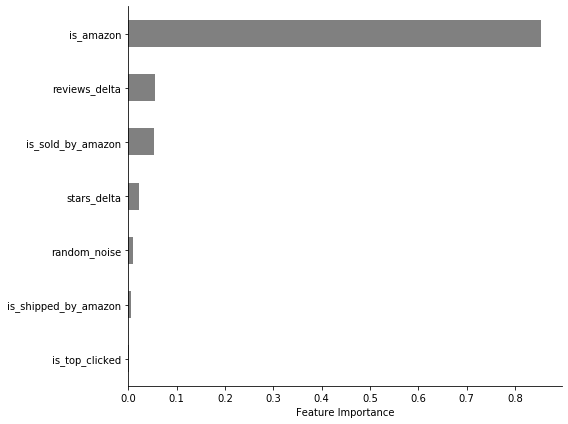

In [13]:
# initiate the model
forest = RandomForestClassifier(n_estimators=n_trees, 
                                max_depth=max_tree_depth, 
                                max_features=max_features,
                                n_jobs=-1, random_state=random_seed)
# fit the model
score = fit_model(training_data, variable=cols, target=target, model=forest)

# get the feature importance
forest_importances = pd.Series(forest.feature_importances_, index=cols)
forest_importances.sort_values(inplace=True, ascending=True)

# plot the feature importance
fig, ax = plt.subplots(figsize=(8, 6))
forest_importances.plot.barh(ax=ax, color='grey')
ax.set_xlabel("Feature Importance")

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom') # Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
fig.tight_layout()

## Ablation
How we re-train the model with the entire dataset, and then with columns knocked out one-by-one, and alone one-by-one.

We use k-folds cross-vaildation below in `fit_model_cv` (CV stands for cross-validation) to evalute the model trained on K (10) different sub-sections of the data.

In [15]:
def fit_model_cv(df, variable, target, model, cv=10):
    """Fits a model and gets mean accuracy from k-folds cross validation"""
    is_multivariate = True if isinstance(variable, list) else False   
    X = df[variable]
    y = df[target]
    X_2d = X if is_multivariate else np.expand_dims(X.values, axis=1)
    scores = cross_val_score(model, X, y, cv=cv)
    accuracy = scores.mean()
    std = scores.std()
    return accuracy, std

In [16]:
cat2performance = {}
forest = RandomForestClassifier(n_estimators=n_trees, 
                                max_depth=max_tree_depth, 
                                max_features=max_features,
                                n_jobs=-1, random_state=random_seed)
score, std = fit_model_cv(training_data, variable=cols, target=target, model=forest)
print(f"All features: {score * 100 :.4}%")
cat2performance["All Features"] = score

# train the model with one feature removed at a time.
for col in cols:
    clf =  RandomForestClassifier(n_estimators=n_trees, 
                                  max_depth=max_tree_depth,
                                  max_features=max_features,
                                  n_jobs=-1, random_state=random_seed)
    # knock out the column
    iv = [c for c in cols if c not in col]
    score, std = fit_model_cv(training_data, variable=iv, target=target, model=clf)
    print(f"without {col}: {score * 100 :.4} +/- {std * 100 :.2}%")
    cat2performance[f"without {col}"] = score

All features: 73.15%
without stars_delta: 71.95 +/- 4.1%
without reviews_delta: 69.9 +/- 2.6%
without is_amazon: 63.47 +/- 4.7%
without is_shipped_by_amazon: 71.95 +/- 3.8%
without is_sold_by_amazon: 72.44 +/- 3.9%
without is_top_clicked: 72.16 +/- 4.0%
without random_noise: 72.3 +/- 4.0%


In [17]:
# train the model with just on feature at a time.
cat2performance_standalone = {}
for col in cols:
    clf =  RandomForestClassifier(n_estimators=n_trees,
                                  max_depth=max_tree_depth,
                                  n_jobs=-1, random_state=random_seed)
    score, std = fit_model_cv(training_data, variable=[col], target=target, model=clf)
    print(f"with just {col}: {score * 100 :.4} +/- {std * 100 :.2}%")
    cat2performance_standalone[f"with just {col}"] = score

with just stars_delta: 54.48 +/- 3.3%
with just reviews_delta: 51.95 +/- 3.5%
with just is_amazon: 70.67 +/- 2.6%
with just is_shipped_by_amazon: 51.8 +/- 3.6%
with just is_sold_by_amazon: 61.49 +/- 4.2%
with just is_top_clicked: 54.91 +/- 2.4%
with just random_noise: 49.26 +/- 3.7%


## Logistic regression

We'll implement this in statsmodel.

Here's the notation for recording the DV and the IVs: `DV ~ IV0 + ... + IVn`

In [18]:
formula = 'placed_higher ~ is_amazon + stars_delta + reviews_delta + is_shipped_by_amazon + is_sold_by_amazon + is_amazon + is_top_clicked + random_noise'

In [19]:
# how to fit the logistic regression:
results = smf.logit(formula=formula, data=df).fit(disp=0)

In [20]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          placed_higher   No. Observations:                 1415
Model:                          Logit   Df Residuals:                     1407
Method:                           MLE   Df Model:                            7
Date:                Mon, 07 Aug 2023   Pseudo R-squ.:                  0.2990
Time:                        18:24:28   Log-Likelihood:                -687.51
converged:                       True   LL-Null:                       -980.72
Covariance Type:            nonrobust   LLR p-value:                2.039e-122
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.0758      0.066      1.147      0.252      -0.054       0.205
is_amazon                1.1647      0.081     14.441      0.000       1.007       1.323
stars_delta             -0.2832      0.203     -1.393      0.164      -0.682       0.115
reviews_delta        -1.569e-06   1.16e-06     -1.351      0.177   -3.84e-06    7.07e-07
is_shipped_by_amazon    -0.0285      0.101     -0.281      0.778      -0.227       0.170
is_sold_by_amazon        0.3195      0.076      4.217      0.000       0.171       0.468
is_top_clicked           0.0156      0.065      0.241      0.810      -0.112       0.143
random_noise            -0.0199      0.048     -0.418      0.676      -0.113       0.074
========================================================================================
"""

In [21]:
table = pd.DataFrame({
    'variables': results.params.keys(),
    'coef': results.params.values,
    'odds_ratio': np.exp(results.params.values),
    
})

In [22]:
table['intercept'] = results.params['Intercept']


In [23]:
def odds_to_probability(row, step=1):
    """
    See about this equation here:
    http://faculty.cas.usf.edu/mbrannick/regression/Logistic.html
    """
    a = row['intercept']
    b = row['coef']
    X = step
    try:
        return math.exp(a + b * X) / (1 + math.exp(a + b * X))
    except:
        return None

In [24]:
# get the baseline probability of the outcome controlling for other factors.
table['probability'] = table.apply(odds_to_probability, axis=1)

In [26]:
table

,variables,coef,odds_ratio,intercept,probability
0,Intercept,0.075831,1.078780,0.075831,0.537843
1,is_amazon,1.164743,3.205098,0.075831,0.775664
2,stars_delta,-0.283157,0.753402,0.075831,0.448353
3,reviews_delta,-0.000002,0.999998,0.075831,0.518948
4,is_shipped_by_amazon,-0.028490,0.971912,0.075831,0.511833
5,is_sold_by_amazon,0.319513,1.376458,0.075831,0.597569
6,is_top_clicked,0.015636,1.015759,0.075831,0.522851
7,random_noise,-0.019943,0.980255,0.075831,0.513968


## McFadden's psuedo R-squared
This is a goodness of fit metric. You want this number to be close to 1, but nothing really every gets above 0.7.

In [27]:
results.prsquared

0.2989757792343801

The odds of an Amazon product getting in the number one spotis 3.2x greater than the odds of a non-Amazon product getting the number one spot.